In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.ESN_v4 import ESN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-20 20:52:32.442842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 20:52:32.443318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 20:52:32.519689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 20:52:32.520007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 20:52:32.520351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_ESN'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'ESN_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use
    
    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    use_ae_data = params_dict['use_ae_data']
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

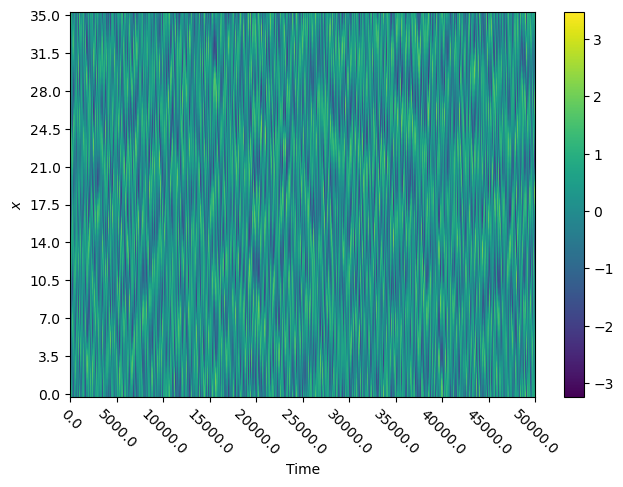

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

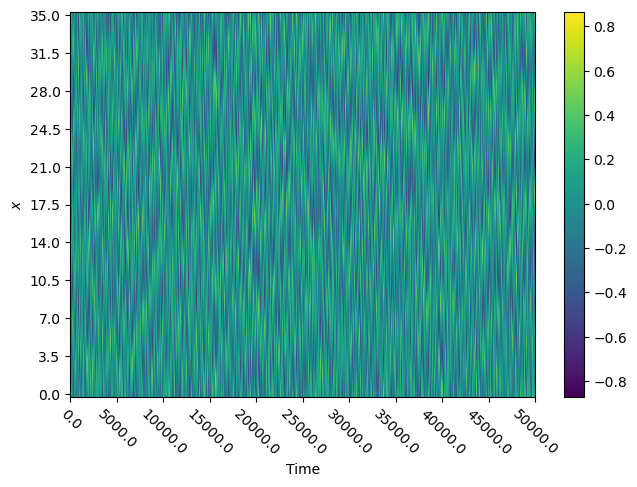

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

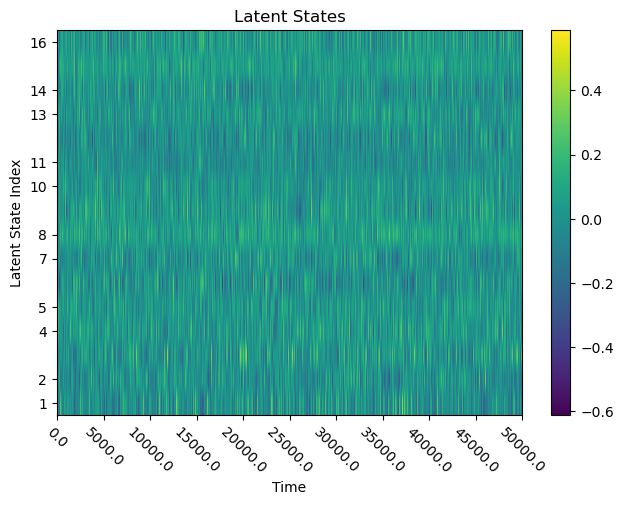

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# ESN

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.2
    num_input_tsteps = 375
    T_sample_input = num_input_tsteps*dt_rnn
    T_sample_output = T_sample_input
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    ESN_layers_units = [500]
    stateful = True
    omega_in = [1.0]
    degree_of_connectivity = [10]
    rho_res = [0.5]
    usebias_Win = [False]
    alpha = [0.95]
    ESN_cell_activations = ['tanh']
    usebias_Wout = True
    
    activation_post_Wout = 'tanh'
    use_weights_post_dense = True
    
    # computing sparsity
    sparsity = [1-degree_of_connectivity[i]/(ESN_layers_units[i]-1) for i in range(len(ESN_layers_units))]
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_input_tsteps':num_input_tsteps,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':ESN.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    epochs = 3
    lambda_reg = 1e-4 # weight for regularizer
    min_delta = 1e-6
    patience = 5
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 1
    fRMS = 0.25/100
    use_best = False

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'epochs':epochs,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'lambda_reg':lambda_reg,
        'min_delta':min_delta,
        'patience':patience,
        'use_best':use_best,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    epochs = tparams_dict['epochs']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    lambda_reg = tparams_dict['lambda_reg']
    min_delta = tparams_dict['min_delta']
    patience = tparams_dict['patience']
    try:
        use_best = tparams_dict['use_best']
    except:
        print("'use_best' not present in 'training_specific_params', set to True.")
        use_best = True

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
# idx = np.arange(0, training_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
# training_data_rnn_output = training_data_rnn_output[idx]

# idx = np.arange(0, val_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# val_data_rnn_input = val_data_rnn_input[idx]
# val_data_rnn_output = val_data_rnn_output[idx]

# idx = np.arange(0, testing_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# testing_data_rnn_input = testing_data_rnn_input[idx]
# testing_data_rnn_output = testing_data_rnn_output[idx]

# del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (531, 375, 16)
 testing_data_rnn_input.shape :  (67, 375, 16)
     val_data_rnn_input.shape :  (66, 375, 16)


In [30]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states


    rnn_net = ESN(
        data_dim=data_dim,
        dt_rnn=dt_rnn,
        lambda_reg=lambda_reg,
        ESN_layers_units=ESN_layers_units,
        stddev=stddev,
        noise_type=noise_type,
        stateful=stateful,
        omega_in=omega_in,
        sparsity=sparsity,
        rho_res=rho_res,
        usebias_Win=usebias_Win,
        alpha=alpha,
        ESN_cell_activations=ESN_cell_activations,
        prng_seed=prng_seed,
        usebias_Wout=usebias_Wout,
        use_weights_post_dense=use_weights_post_dense,
        activation_post_Wout=activation_post_Wout,
    )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.build(input_shape=(1,) + training_data_rnn_input.shape[1:])
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    
    rnn_net = ESN(
        load_file=load_file,
    )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_ESN_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33066237
stddev : 0.000826655924320221


In [31]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
# elif behaviour == 'loadCheckpointAndContinueTraining':
#     val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
#         dir_name_ae=dir_name_rnn,
#         dir_sep=dir_sep,
#         epochs=epochs,
#         learning_rate_list=learning_rate_list,
#         return_earlystopping_wait=True)
#     savelosses_cb_vallossarr = val_loss_arr_fromckpt
#     savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [32]:
def invert_fn(y):
    # post_Wout_activation = 'linear'
    return y

# def invert_fn(y):
#     # post_Wout_activation = 'tanh'
#     y = np.where(y < 1.0, y, 1-1e-6)
#     y = np.where(y > -1.0, y, -1+1e-6)
#     y = 0.5*(np.log(1+y) - np.log(1-y))
#     return y
    

In [33]:
training_data_rnn_input.dtype

dtype('float32')

In [34]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=losses.MeanSquaredError(),
    metrics=['mse'],
    run_eagerly=False
)

lambda_reg = float(lambda_reg)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    rnn_net.load_weights(wt_file)
    
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':

    Wout_best = 0
    val_mse_best = np.inf
    Wout_candidate = 0
    wait = 0
    if use_weights_post_dense == True:
        postWout_candidate = 0
        h_activation = tf.keras.activations.get(activation_post_Wout)
    
    
    hidden_units = ESN_layers_units[-1]
    output_units = rnn_net.data_dim
    
    Hb_shape = [hidden_units, hidden_units]
    Yb_shape = [output_units, hidden_units]
    if usebias_Wout == True:
        Hb_shape[0] += 1
        Hb_shape[1] += 1
        Yb_shape[1] += 1
        
    Hb = np.zeros(shape=Hb_shape, dtype=FTYPE)
    Yb = np.zeros(shape=Yb_shape, dtype=FTYPE)
    eye_Hb = np.eye(Hb.shape[0], dtype=FTYPE)

    num_batches = training_data_rnn_input.shape[0]
    
    
    for i in range(epochs):
        # for layer in rnn_net.ESN_layers:
        #     layer.reset_states()

        epoch_totaltime = time.time()

        total_s_len = 80
        sep_lr_s = ' EPOCH : {} '.format(i+1)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')

        # '''
        ### computing Wout
        Hb = 0
        Yb = 0
        epoch_time = time.time()
        for j in range(training_data_rnn_input.shape[0]):
            batch_time = time.time()
            h = np.array(rnn_net(training_data_rnn_input[j:j+1], manual_training=True))
            # h = rnn_net(training_data_rnn_input[j:j+1], training=True)
            # print(h.shape)
            h = h[0]
            # y = tf.constant(training_data_rnn_output[j])
            y = invert_fn(training_data_rnn_output[j])
            if usebias_Wout == True:
                h = np.concatenate((h, np.ones(shape=(h.shape[0], 1))), axis=1)
            Hb = Hb + np.matmul(np.transpose(h), h)
            Yb = Yb + np.matmul(np.transpose(y), h)
            # Hb = Hb + tf.linalg.matmul(tf.transpose(h), h)
            # Yb = Yb + tf.linalg.matmul(tf.transpose(y), h)

            print('{} / {} -- Wout batch_time : {} sec'.format(
                j+1,
                training_data_rnn_input.shape[0],
                time.time() - batch_time
            ))

        Wout = np.matmul(
            Yb,
            np.linalg.inv(Hb + lambda_reg*np.eye(Hb.shape[0]))
        )
        Wout = np.transpose(Wout)
        # Wout = tf.linalg.matmul(
        #     Yb,
        #     tf.linalg.inv(Hb + lambda_reg*tf.eye(Hb.shape[0]))
        # )
        # Wout = tf.transpose(Wout)
        
        if use_weights_post_dense == True:
            ### computing postWout
            HYb = 0
            HHb = 0
            for j in range(training_data_rnn_input.shape[0]):
                batch_time = time.time()
                h = np.array(rnn_net(training_data_rnn_input[j:j+1], manual_training=True))
                # h = rnn_net(training_data_rnn_input[j:j+1], training=True)
                # print(h.shape)
                h = h[0]
                h = np.matmul(h, Wout[0:ESN_layers_units[-1], :])
                if usebias_Wout == True:
                    h = h + Wout[ESN_layers_units[-1]:, :]
                # y = tf.constant(training_data_rnn_output[j])
                h = np.array(h_activation(h))
                y = training_data_rnn_output[j]
                HYb = HYb + np.sum(h*y, axis=0)
                HHb = HHb + np.sum(h**2, axis=0)
                # Hb = Hb + tf.linalg.matmul(tf.transpose(h), h)
                # Yb = Yb + tf.linalg.matmul(tf.transpose(y), h)

                print('{} / {} -- postWout batch_time : {} sec'.format(
                    j+1,
                    training_data_rnn_input.shape[0],
                    time.time() - batch_time
                ))
                
            postWout = HYb / (HHb + lambda_reg)

        print('\nepoch_time : {} sec'.format(time.time() - epoch_time))
        
        '''
        epoch_time = time.time()
        Wout = batched_computation(
            num_batches,
            rnn_net,
            training_data_rnn_input,
            training_data_rnn_output,
            usebias_Wout,
            Hb, Yb,
            hidden_units, output_units,
            lambda_reg, eye_Hb)
        print('\nepoch_time : {} sec'.format(time.time() - epoch_time))

        Hb[:, :] = 0.0
        Yb[:, :] = 0.0
        '''
    
        Wout_candidate = Wout_candidate*i/(i+1) + Wout*1/(i+1)
        tf.keras.backend.set_value(rnn_net.Wout.kernel, Wout_candidate[0:ESN_layers_units[-1], :])
        if usebias_Wout == True:
            tf.keras.backend.set_value(rnn_net.Wout.bias, Wout_candidate[-1, :])

        if use_weights_post_dense == True:
            postWout_candidate = postWout_candidate*i/(i+1) + postWout*1/(i+1)
            tf.keras.backend.set_value(rnn_net.postWout.individual_weights, postWout_candidate)

        for layer in rnn_net.ESN_layers:
            layer.reset_states()

        print('\nval mse')
        # '''
        val_mse = 0
        for j in range(val_data_rnn_input.shape[0]):
            batch_time = time.time()
            val_pred = np.array(rnn_net(val_data_rnn_input[j:j+1], manual_training=False))
            temp = (val_pred - val_data_rnn_output[j:j+1])**2
            temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
            temp = np.mean(temp, axis=-1)
            temp = np.mean(temp, axis=-1)
            val_mse = val_mse*j/(j+1) + temp*1/(j+1)
            print('{} / {} -- batch_time : {} sec'.format(
                j+1,
                val_data_rnn_input.shape[0],
                time.time() - batch_time
            ))
        '''
        mse_time = time.time()
        val_mse = compute_mse(
            val_data_rnn_input,
            val_data_rnn_output,
            rnn_net)
        mse_time = time.time() - mse_time
        print('val_mse compute time : {} sec'.format(mse_time))
        '''

        for layer in rnn_net.ESN_layers:
            layer.reset_states()

        print('\ntraining mse')
        # '''
        train_mse = 0
        for j in range(training_data_rnn_input.shape[0]):
            batch_time = time.time()
            train_pred = np.array(rnn_net(training_data_rnn_input[j:j+1], manual_training=False))
            temp = (train_pred - training_data_rnn_output[j:j+1])**2
            temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
            temp = np.mean(temp, axis=-1)
            temp = np.mean(temp, axis=-1)
            train_mse = train_mse*j/(j+1) + temp*1/(j+1)
            print('{} / {} -- batch_time : {} sec'.format(
                j+1,
                training_data_rnn_input.shape[0],
                time.time() - batch_time
            ))
        '''
        mse_time = time.time()
        train_mse = compute_mse(
            training_data_rnn_input,
            training_data_rnn_output,
            rnn_net)
        mse_time = time.time() - mse_time
        print('train_mse compute time : {} sec'.format(mse_time))
        '''

        for layer in rnn_net.ESN_layers:
            layer.reset_states()

#         print('\ntesting mse')
#         test_mse = 0
#         for j in range(testing_data_rnn_input.shape[0]):
#             print('{} / {}'.format(j+1, testing_data_rnn_input.shape[0]))
#             test_pred = np.array(rnn_net(testing_data_rnn_input[j:j+1], training=False))
#             temp = (test_pred - testing_data_rnn_output[j:j+1])**2
#             temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
#             temp = np.mean(temp, axis=-1)
#             temp = np.mean(temp, axis=-1)
#             test_mse = test_mse*j/(j+1) + temp*1/(j+1)
        
#         for layer in rnn_net.ESN_layers:
#             layer.reset_states()

        val_loss_hist.append(val_mse)
        train_loss_hist.append(train_mse)
        
        # print('\ntest_mse : {}'.format(test_mse))
        print('\ntrain_mse : {}'.format(train_mse))
        print('val_mse : {}'.format(val_mse))
        if val_mse + min_delta <= val_mse_best:
            print('val_mse improved from {}'.format(val_mse_best))
            Wout_best = Wout_candidate
            val_mse_best = val_mse
            wait = 0
        else:
            wait += 1
            print('val_mse did not improve from {}, wait : {}'.format(val_mse_best, wait))

        print('\nTotal epoch computation time : {} sec'.format(time.time()-epoch_totaltime))
            
        if wait >= patience:
            print('\nearly stopping')
            break
        
#         val_loss_hist.extend(history.history['val_loss'])
#         train_loss_hist.extend(history.history['loss'])
        
#         if i == starting_lr_idx:
#             lr_change[i+1] += len(history.history['val_loss'])
#         else:
#             lr_change.append(lr_change[i]+len(history.history['val_loss']))

# tf.keras.backend.set_value(rnn_net.Wout, Wout_best)

if use_best == True:
    tf.keras.backend.set_value(rnn_net.Wout.kernel, Wout_best[0:ESN_layers_units[-1], :])
    if usebias_Wout == True:
        tf.keras.backend.set_value(rnn_net.Wout.bias, Wout_best[-1, :])
print('\ntest mse')
test_mse = 0
for j in range(testing_data_rnn_input.shape[0]):
    print('{} / {}'.format(j+1, testing_data_rnn_input.shape[0]))
    test_pred = np.array(rnn_net(testing_data_rnn_input[j:j+1], manual_training=False))
    temp = (test_pred - testing_data_rnn_output[j:j+1])**2
    temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
    temp = np.mean(temp, axis=-1)
    temp = np.mean(temp, axis=-1)
    test_mse = test_mse*j/(j+1) + temp*1/(j+1)
print('test_mse : {}'.format(test_mse))

for layer in rnn_net.ESN_layers:
    layer.reset_states()



--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 531 -- Wout batch_time : 0.22698593139648438 sec
2 / 531 -- Wout batch_time : 0.0894017219543457 sec
3 / 531 -- Wout batch_time : 0.08115649223327637 sec
4 / 531 -- Wout batch_time : 0.08417153358459473 sec
5 / 531 -- Wout batch_time : 0.08495092391967773 sec
6 / 531 -- Wout batch_time : 0.08847427368164062 sec
7 / 531 -- Wout batch_time : 0.08710980415344238 sec
8 / 531 -- Wout batch_time : 0.05547142028808594 sec
9 / 531 -- Wout batch_time : 0.051845550537109375 sec
10 / 531 -- Wout batch_time : 0.06437063217163086 sec
11 / 531 -- Wout batch_time : 0.066436767578125 sec
12 / 531 -- Wout batch_time : 0.05686163902282715 sec
13 / 531 -- Wout batch_time : 0.05947399139404297 sec
14 / 531 -- Wout batch_time : 0.0564885139465332 sec
15 / 53

149 / 531 -- Wout batch_time : 0.06240034103393555 sec
150 / 531 -- Wout batch_time : 0.06309819221496582 sec
151 / 531 -- Wout batch_time : 0.06700611114501953 sec
152 / 531 -- Wout batch_time : 0.05868816375732422 sec
153 / 531 -- Wout batch_time : 0.08073663711547852 sec
154 / 531 -- Wout batch_time : 0.05704760551452637 sec
155 / 531 -- Wout batch_time : 0.05633425712585449 sec
156 / 531 -- Wout batch_time : 0.05606198310852051 sec
157 / 531 -- Wout batch_time : 0.055744171142578125 sec
158 / 531 -- Wout batch_time : 0.05643939971923828 sec
159 / 531 -- Wout batch_time : 0.055524349212646484 sec
160 / 531 -- Wout batch_time : 0.09469771385192871 sec
161 / 531 -- Wout batch_time : 0.06728506088256836 sec
162 / 531 -- Wout batch_time : 0.05514097213745117 sec
163 / 531 -- Wout batch_time : 0.055185794830322266 sec
164 / 531 -- Wout batch_time : 0.0648202896118164 sec
165 / 531 -- Wout batch_time : 0.05927920341491699 sec
166 / 531 -- Wout batch_time : 0.05513906478881836 sec
167 / 53

302 / 531 -- Wout batch_time : 0.06579804420471191 sec
303 / 531 -- Wout batch_time : 0.06636238098144531 sec
304 / 531 -- Wout batch_time : 0.06641912460327148 sec
305 / 531 -- Wout batch_time : 0.06522727012634277 sec
306 / 531 -- Wout batch_time : 0.06935524940490723 sec
307 / 531 -- Wout batch_time : 0.0650482177734375 sec
308 / 531 -- Wout batch_time : 0.06544375419616699 sec
309 / 531 -- Wout batch_time : 0.05694270133972168 sec
310 / 531 -- Wout batch_time : 0.0656576156616211 sec
311 / 531 -- Wout batch_time : 0.057630300521850586 sec
312 / 531 -- Wout batch_time : 0.05961418151855469 sec
313 / 531 -- Wout batch_time : 0.08608508110046387 sec
314 / 531 -- Wout batch_time : 0.0819401741027832 sec
315 / 531 -- Wout batch_time : 0.06489253044128418 sec
316 / 531 -- Wout batch_time : 0.07415437698364258 sec
317 / 531 -- Wout batch_time : 0.05941462516784668 sec
318 / 531 -- Wout batch_time : 0.06059384346008301 sec
319 / 531 -- Wout batch_time : 0.0693058967590332 sec
320 / 531 -- 

453 / 531 -- Wout batch_time : 0.057172298431396484 sec
454 / 531 -- Wout batch_time : 0.055797576904296875 sec
455 / 531 -- Wout batch_time : 0.05634880065917969 sec
456 / 531 -- Wout batch_time : 0.056066274642944336 sec
457 / 531 -- Wout batch_time : 0.056801795959472656 sec
458 / 531 -- Wout batch_time : 0.05696439743041992 sec
459 / 531 -- Wout batch_time : 0.058129072189331055 sec
460 / 531 -- Wout batch_time : 0.05653572082519531 sec
461 / 531 -- Wout batch_time : 0.05581784248352051 sec
462 / 531 -- Wout batch_time : 0.05651688575744629 sec
463 / 531 -- Wout batch_time : 0.056061506271362305 sec
464 / 531 -- Wout batch_time : 0.055721282958984375 sec
465 / 531 -- Wout batch_time : 0.05642247200012207 sec
466 / 531 -- Wout batch_time : 0.05645918846130371 sec
467 / 531 -- Wout batch_time : 0.05545806884765625 sec
468 / 531 -- Wout batch_time : 0.05690360069274902 sec
469 / 531 -- Wout batch_time : 0.0563809871673584 sec
470 / 531 -- Wout batch_time : 0.05643320083618164 sec
471 

70 / 531 -- postWout batch_time : 0.05523562431335449 sec
71 / 531 -- postWout batch_time : 0.06023049354553223 sec
72 / 531 -- postWout batch_time : 0.056319475173950195 sec
73 / 531 -- postWout batch_time : 0.0546724796295166 sec
74 / 531 -- postWout batch_time : 0.05513334274291992 sec
75 / 531 -- postWout batch_time : 0.0580601692199707 sec
76 / 531 -- postWout batch_time : 0.055100202560424805 sec
77 / 531 -- postWout batch_time : 0.05600595474243164 sec
78 / 531 -- postWout batch_time : 0.09852480888366699 sec
79 / 531 -- postWout batch_time : 0.05750632286071777 sec
80 / 531 -- postWout batch_time : 0.08178305625915527 sec
81 / 531 -- postWout batch_time : 0.08511042594909668 sec
82 / 531 -- postWout batch_time : 0.08427143096923828 sec
83 / 531 -- postWout batch_time : 0.08519101142883301 sec
84 / 531 -- postWout batch_time : 0.08725380897521973 sec
85 / 531 -- postWout batch_time : 0.060228586196899414 sec
86 / 531 -- postWout batch_time : 0.05355691909790039 sec
87 / 531 -- p

211 / 531 -- postWout batch_time : 0.07657051086425781 sec
212 / 531 -- postWout batch_time : 0.06767439842224121 sec
213 / 531 -- postWout batch_time : 0.06226181983947754 sec
214 / 531 -- postWout batch_time : 0.06265711784362793 sec
215 / 531 -- postWout batch_time : 0.054280757904052734 sec
216 / 531 -- postWout batch_time : 0.06027674674987793 sec
217 / 531 -- postWout batch_time : 0.05447578430175781 sec
218 / 531 -- postWout batch_time : 0.053861141204833984 sec
219 / 531 -- postWout batch_time : 0.05398726463317871 sec
220 / 531 -- postWout batch_time : 0.054869890213012695 sec
221 / 531 -- postWout batch_time : 0.05382275581359863 sec
222 / 531 -- postWout batch_time : 0.054250478744506836 sec
223 / 531 -- postWout batch_time : 0.05363297462463379 sec
224 / 531 -- postWout batch_time : 0.05391812324523926 sec
225 / 531 -- postWout batch_time : 0.054660797119140625 sec
226 / 531 -- postWout batch_time : 0.05902457237243652 sec
227 / 531 -- postWout batch_time : 0.08153867721557

350 / 531 -- postWout batch_time : 0.054288387298583984 sec
351 / 531 -- postWout batch_time : 0.054785966873168945 sec
352 / 531 -- postWout batch_time : 0.05470108985900879 sec
353 / 531 -- postWout batch_time : 0.05420351028442383 sec
354 / 531 -- postWout batch_time : 0.05460524559020996 sec
355 / 531 -- postWout batch_time : 0.05641603469848633 sec
356 / 531 -- postWout batch_time : 0.07094621658325195 sec
357 / 531 -- postWout batch_time : 0.0657804012298584 sec
358 / 531 -- postWout batch_time : 0.05735182762145996 sec
359 / 531 -- postWout batch_time : 0.0669240951538086 sec
360 / 531 -- postWout batch_time : 0.07857656478881836 sec
361 / 531 -- postWout batch_time : 0.07564830780029297 sec
362 / 531 -- postWout batch_time : 0.05443215370178223 sec
363 / 531 -- postWout batch_time : 0.05595850944519043 sec
364 / 531 -- postWout batch_time : 0.06790328025817871 sec
365 / 531 -- postWout batch_time : 0.06627416610717773 sec
366 / 531 -- postWout batch_time : 0.057675838470458984 

490 / 531 -- postWout batch_time : 0.09234261512756348 sec
491 / 531 -- postWout batch_time : 0.07705330848693848 sec
492 / 531 -- postWout batch_time : 0.048584699630737305 sec
493 / 531 -- postWout batch_time : 0.07239389419555664 sec
494 / 531 -- postWout batch_time : 0.06020760536193848 sec
495 / 531 -- postWout batch_time : 0.06286954879760742 sec
496 / 531 -- postWout batch_time : 0.10589003562927246 sec
497 / 531 -- postWout batch_time : 0.07541537284851074 sec
498 / 531 -- postWout batch_time : 0.0923459529876709 sec
499 / 531 -- postWout batch_time : 0.05602121353149414 sec
500 / 531 -- postWout batch_time : 0.06922149658203125 sec
501 / 531 -- postWout batch_time : 0.07483339309692383 sec
502 / 531 -- postWout batch_time : 0.06125330924987793 sec
503 / 531 -- postWout batch_time : 0.05979561805725098 sec
504 / 531 -- postWout batch_time : 0.07743406295776367 sec
505 / 531 -- postWout batch_time : 0.06062459945678711 sec
506 / 531 -- postWout batch_time : 0.05623483657836914 s

53 / 531 -- batch_time : 0.1871492862701416 sec
54 / 531 -- batch_time : 0.17827153205871582 sec
55 / 531 -- batch_time : 0.15333962440490723 sec
56 / 531 -- batch_time : 0.15214943885803223 sec
57 / 531 -- batch_time : 0.17547369003295898 sec
58 / 531 -- batch_time : 0.1540682315826416 sec
59 / 531 -- batch_time : 0.19668817520141602 sec
60 / 531 -- batch_time : 0.15272259712219238 sec
61 / 531 -- batch_time : 0.16994762420654297 sec
62 / 531 -- batch_time : 0.17113256454467773 sec
63 / 531 -- batch_time : 0.1918473243713379 sec
64 / 531 -- batch_time : 0.15562176704406738 sec
65 / 531 -- batch_time : 0.18691706657409668 sec
66 / 531 -- batch_time : 0.17342901229858398 sec
67 / 531 -- batch_time : 0.17859458923339844 sec
68 / 531 -- batch_time : 0.1614086627960205 sec
69 / 531 -- batch_time : 0.15362334251403809 sec
70 / 531 -- batch_time : 0.16852378845214844 sec
71 / 531 -- batch_time : 0.16667795181274414 sec
72 / 531 -- batch_time : 0.20002198219299316 sec
73 / 531 -- batch_time :

220 / 531 -- batch_time : 0.17496585845947266 sec
221 / 531 -- batch_time : 0.15650725364685059 sec
222 / 531 -- batch_time : 0.15880131721496582 sec
223 / 531 -- batch_time : 0.17195510864257812 sec
224 / 531 -- batch_time : 0.17217111587524414 sec
225 / 531 -- batch_time : 0.16266584396362305 sec
226 / 531 -- batch_time : 0.17224907875061035 sec
227 / 531 -- batch_time : 0.15278935432434082 sec
228 / 531 -- batch_time : 0.17395472526550293 sec
229 / 531 -- batch_time : 0.1952192783355713 sec
230 / 531 -- batch_time : 0.15504074096679688 sec
231 / 531 -- batch_time : 0.1523418426513672 sec
232 / 531 -- batch_time : 0.1831963062286377 sec
233 / 531 -- batch_time : 0.18041110038757324 sec
234 / 531 -- batch_time : 0.1685776710510254 sec
235 / 531 -- batch_time : 0.1646733283996582 sec
236 / 531 -- batch_time : 0.15382814407348633 sec
237 / 531 -- batch_time : 0.16208934783935547 sec
238 / 531 -- batch_time : 0.16988039016723633 sec
239 / 531 -- batch_time : 0.17606639862060547 sec
240 /

385 / 531 -- batch_time : 0.1739513874053955 sec
386 / 531 -- batch_time : 0.16996335983276367 sec
387 / 531 -- batch_time : 0.16215944290161133 sec
388 / 531 -- batch_time : 0.16054129600524902 sec
389 / 531 -- batch_time : 0.20406579971313477 sec
390 / 531 -- batch_time : 0.1524488925933838 sec
391 / 531 -- batch_time : 0.16979002952575684 sec
392 / 531 -- batch_time : 0.15251970291137695 sec
393 / 531 -- batch_time : 0.15299344062805176 sec
394 / 531 -- batch_time : 0.15252900123596191 sec
395 / 531 -- batch_time : 0.15336346626281738 sec
396 / 531 -- batch_time : 0.15190339088439941 sec
397 / 531 -- batch_time : 0.15336275100708008 sec
398 / 531 -- batch_time : 0.15189385414123535 sec
399 / 531 -- batch_time : 0.1533207893371582 sec
400 / 531 -- batch_time : 0.15645742416381836 sec
401 / 531 -- batch_time : 0.1737205982208252 sec
402 / 531 -- batch_time : 0.15338826179504395 sec
403 / 531 -- batch_time : 0.16096806526184082 sec
404 / 531 -- batch_time : 0.15881752967834473 sec
405 

12 / 531 -- Wout batch_time : 0.08896946907043457 sec
13 / 531 -- Wout batch_time : 0.06229710578918457 sec
14 / 531 -- Wout batch_time : 0.0684506893157959 sec
15 / 531 -- Wout batch_time : 0.07962989807128906 sec
16 / 531 -- Wout batch_time : 0.05556368827819824 sec
17 / 531 -- Wout batch_time : 0.060157060623168945 sec
18 / 531 -- Wout batch_time : 0.05776023864746094 sec
19 / 531 -- Wout batch_time : 0.08498597145080566 sec
20 / 531 -- Wout batch_time : 0.06638455390930176 sec
21 / 531 -- Wout batch_time : 0.060225486755371094 sec
22 / 531 -- Wout batch_time : 0.08205747604370117 sec
23 / 531 -- Wout batch_time : 0.08434653282165527 sec
24 / 531 -- Wout batch_time : 0.0675497055053711 sec
25 / 531 -- Wout batch_time : 0.059342145919799805 sec
26 / 531 -- Wout batch_time : 0.09036135673522949 sec
27 / 531 -- Wout batch_time : 0.05576968193054199 sec
28 / 531 -- Wout batch_time : 0.05954241752624512 sec
29 / 531 -- Wout batch_time : 0.056404829025268555 sec
30 / 531 -- Wout batch_tim

164 / 531 -- Wout batch_time : 0.05613303184509277 sec
165 / 531 -- Wout batch_time : 0.05596590042114258 sec
166 / 531 -- Wout batch_time : 0.05600738525390625 sec
167 / 531 -- Wout batch_time : 0.05606842041015625 sec
168 / 531 -- Wout batch_time : 0.055890560150146484 sec
169 / 531 -- Wout batch_time : 0.055960655212402344 sec
170 / 531 -- Wout batch_time : 0.06289243698120117 sec
171 / 531 -- Wout batch_time : 0.05589604377746582 sec
172 / 531 -- Wout batch_time : 0.05622386932373047 sec
173 / 531 -- Wout batch_time : 0.06055736541748047 sec
174 / 531 -- Wout batch_time : 0.06682729721069336 sec
175 / 531 -- Wout batch_time : 0.057547569274902344 sec
176 / 531 -- Wout batch_time : 0.06140279769897461 sec
177 / 531 -- Wout batch_time : 0.056493520736694336 sec
178 / 531 -- Wout batch_time : 0.056058406829833984 sec
179 / 531 -- Wout batch_time : 0.08132052421569824 sec
180 / 531 -- Wout batch_time : 0.056329965591430664 sec
181 / 531 -- Wout batch_time : 0.07252073287963867 sec
182 

314 / 531 -- Wout batch_time : 0.05978798866271973 sec
315 / 531 -- Wout batch_time : 0.056659698486328125 sec
316 / 531 -- Wout batch_time : 0.056597232818603516 sec
317 / 531 -- Wout batch_time : 0.05666184425354004 sec
318 / 531 -- Wout batch_time : 0.05954766273498535 sec
319 / 531 -- Wout batch_time : 0.056369781494140625 sec
320 / 531 -- Wout batch_time : 0.056223392486572266 sec
321 / 531 -- Wout batch_time : 0.05572772026062012 sec
322 / 531 -- Wout batch_time : 0.056060791015625 sec
323 / 531 -- Wout batch_time : 0.056119441986083984 sec
324 / 531 -- Wout batch_time : 0.056337833404541016 sec
325 / 531 -- Wout batch_time : 0.055448293685913086 sec
326 / 531 -- Wout batch_time : 0.05953073501586914 sec
327 / 531 -- Wout batch_time : 0.056166887283325195 sec
328 / 531 -- Wout batch_time : 0.05652284622192383 sec
329 / 531 -- Wout batch_time : 0.05587482452392578 sec
330 / 531 -- Wout batch_time : 0.061968326568603516 sec
331 / 531 -- Wout batch_time : 0.05609750747680664 sec
332

465 / 531 -- Wout batch_time : 0.06292557716369629 sec
466 / 531 -- Wout batch_time : 0.08336353302001953 sec
467 / 531 -- Wout batch_time : 0.05719709396362305 sec
468 / 531 -- Wout batch_time : 0.05478405952453613 sec
469 / 531 -- Wout batch_time : 0.09056735038757324 sec
470 / 531 -- Wout batch_time : 0.06088376045227051 sec
471 / 531 -- Wout batch_time : 0.06348204612731934 sec
472 / 531 -- Wout batch_time : 0.06576919555664062 sec
473 / 531 -- Wout batch_time : 0.06537747383117676 sec
474 / 531 -- Wout batch_time : 0.06244158744812012 sec
475 / 531 -- Wout batch_time : 0.07510781288146973 sec
476 / 531 -- Wout batch_time : 0.06229066848754883 sec
477 / 531 -- Wout batch_time : 0.07946515083312988 sec
478 / 531 -- Wout batch_time : 0.07118630409240723 sec
479 / 531 -- Wout batch_time : 0.09083890914916992 sec
480 / 531 -- Wout batch_time : 0.06807851791381836 sec
481 / 531 -- Wout batch_time : 0.059987545013427734 sec
482 / 531 -- Wout batch_time : 0.056090593338012695 sec
483 / 53

82 / 531 -- postWout batch_time : 0.05623340606689453 sec
83 / 531 -- postWout batch_time : 0.05480456352233887 sec
84 / 531 -- postWout batch_time : 0.05544590950012207 sec
85 / 531 -- postWout batch_time : 0.05516552925109863 sec
86 / 531 -- postWout batch_time : 0.05515313148498535 sec
87 / 531 -- postWout batch_time : 0.05596017837524414 sec
88 / 531 -- postWout batch_time : 0.05447220802307129 sec
89 / 531 -- postWout batch_time : 0.054849863052368164 sec
90 / 531 -- postWout batch_time : 0.05467700958251953 sec
91 / 531 -- postWout batch_time : 0.05419182777404785 sec
92 / 531 -- postWout batch_time : 0.05489850044250488 sec
93 / 531 -- postWout batch_time : 0.05390429496765137 sec
94 / 531 -- postWout batch_time : 0.05446124076843262 sec
95 / 531 -- postWout batch_time : 0.05499529838562012 sec
96 / 531 -- postWout batch_time : 0.05388450622558594 sec
97 / 531 -- postWout batch_time : 0.054273366928100586 sec
98 / 531 -- postWout batch_time : 0.05432009696960449 sec
99 / 531 -- 

225 / 531 -- postWout batch_time : 0.05415081977844238 sec
226 / 531 -- postWout batch_time : 0.05422806739807129 sec
227 / 531 -- postWout batch_time : 0.054193735122680664 sec
228 / 531 -- postWout batch_time : 0.05429339408874512 sec
229 / 531 -- postWout batch_time : 0.05439257621765137 sec
230 / 531 -- postWout batch_time : 0.05439019203186035 sec
231 / 531 -- postWout batch_time : 0.05388903617858887 sec
232 / 531 -- postWout batch_time : 0.05440330505371094 sec
233 / 531 -- postWout batch_time : 0.05426907539367676 sec
234 / 531 -- postWout batch_time : 0.05449271202087402 sec
235 / 531 -- postWout batch_time : 0.05429863929748535 sec
236 / 531 -- postWout batch_time : 0.08002734184265137 sec
237 / 531 -- postWout batch_time : 0.05244278907775879 sec
238 / 531 -- postWout batch_time : 0.052434682846069336 sec
239 / 531 -- postWout batch_time : 0.07463884353637695 sec
240 / 531 -- postWout batch_time : 0.05346393585205078 sec
241 / 531 -- postWout batch_time : 0.05296874046325683

365 / 531 -- postWout batch_time : 0.07882094383239746 sec
366 / 531 -- postWout batch_time : 0.05482673645019531 sec
367 / 531 -- postWout batch_time : 0.08129596710205078 sec
368 / 531 -- postWout batch_time : 0.0718839168548584 sec
369 / 531 -- postWout batch_time : 0.0544431209564209 sec
370 / 531 -- postWout batch_time : 0.054607391357421875 sec
371 / 531 -- postWout batch_time : 0.053641319274902344 sec
372 / 531 -- postWout batch_time : 0.05460715293884277 sec
373 / 531 -- postWout batch_time : 0.05505824089050293 sec
374 / 531 -- postWout batch_time : 0.05353379249572754 sec
375 / 531 -- postWout batch_time : 0.059679508209228516 sec
376 / 531 -- postWout batch_time : 0.07723140716552734 sec
377 / 531 -- postWout batch_time : 0.06090593338012695 sec
378 / 531 -- postWout batch_time : 0.05430459976196289 sec
379 / 531 -- postWout batch_time : 0.06531643867492676 sec
380 / 531 -- postWout batch_time : 0.054937124252319336 sec
381 / 531 -- postWout batch_time : 0.06014132499694824

506 / 531 -- postWout batch_time : 0.05647540092468262 sec
507 / 531 -- postWout batch_time : 0.05749177932739258 sec
508 / 531 -- postWout batch_time : 0.06916522979736328 sec
509 / 531 -- postWout batch_time : 0.05881142616271973 sec
510 / 531 -- postWout batch_time : 0.06395101547241211 sec
511 / 531 -- postWout batch_time : 0.08610677719116211 sec
512 / 531 -- postWout batch_time : 0.06591486930847168 sec
513 / 531 -- postWout batch_time : 0.06830263137817383 sec
514 / 531 -- postWout batch_time : 0.05974626541137695 sec
515 / 531 -- postWout batch_time : 0.05790853500366211 sec
516 / 531 -- postWout batch_time : 0.06288003921508789 sec
517 / 531 -- postWout batch_time : 0.05655050277709961 sec
518 / 531 -- postWout batch_time : 0.07548403739929199 sec
519 / 531 -- postWout batch_time : 0.0639638900756836 sec
520 / 531 -- postWout batch_time : 0.06704235076904297 sec
521 / 531 -- postWout batch_time : 0.056946754455566406 sec
522 / 531 -- postWout batch_time : 0.06770920753479004 s

73 / 531 -- batch_time : 0.1581897735595703 sec
74 / 531 -- batch_time : 0.16356968879699707 sec
75 / 531 -- batch_time : 0.17887258529663086 sec
76 / 531 -- batch_time : 0.15400123596191406 sec
77 / 531 -- batch_time : 0.1798102855682373 sec
78 / 531 -- batch_time : 0.15750694274902344 sec
79 / 531 -- batch_time : 0.15935516357421875 sec
80 / 531 -- batch_time : 0.15507149696350098 sec
81 / 531 -- batch_time : 0.15363240242004395 sec
82 / 531 -- batch_time : 0.17989802360534668 sec
83 / 531 -- batch_time : 0.17197394371032715 sec
84 / 531 -- batch_time : 0.16978192329406738 sec
85 / 531 -- batch_time : 0.15520787239074707 sec
86 / 531 -- batch_time : 0.18553972244262695 sec
87 / 531 -- batch_time : 0.17629408836364746 sec
88 / 531 -- batch_time : 0.17493057250976562 sec
89 / 531 -- batch_time : 0.15530657768249512 sec
90 / 531 -- batch_time : 0.17010760307312012 sec
91 / 531 -- batch_time : 0.1750497817993164 sec
92 / 531 -- batch_time : 0.1531829833984375 sec
93 / 531 -- batch_time :

239 / 531 -- batch_time : 0.15573549270629883 sec
240 / 531 -- batch_time : 0.15288352966308594 sec
241 / 531 -- batch_time : 0.16351723670959473 sec
242 / 531 -- batch_time : 0.15237045288085938 sec
243 / 531 -- batch_time : 0.1717977523803711 sec
244 / 531 -- batch_time : 0.15148234367370605 sec
245 / 531 -- batch_time : 0.18468785285949707 sec
246 / 531 -- batch_time : 0.1545562744140625 sec
247 / 531 -- batch_time : 0.15419816970825195 sec
248 / 531 -- batch_time : 0.1526174545288086 sec
249 / 531 -- batch_time : 0.1869194507598877 sec
250 / 531 -- batch_time : 0.17438340187072754 sec
251 / 531 -- batch_time : 0.1533963680267334 sec
252 / 531 -- batch_time : 0.16903948783874512 sec
253 / 531 -- batch_time : 0.15763092041015625 sec
254 / 531 -- batch_time : 0.16295146942138672 sec
255 / 531 -- batch_time : 0.17008233070373535 sec
256 / 531 -- batch_time : 0.16387581825256348 sec
257 / 531 -- batch_time : 0.20702052116394043 sec
258 / 531 -- batch_time : 0.19260835647583008 sec
259 /

405 / 531 -- batch_time : 0.1540229320526123 sec
406 / 531 -- batch_time : 0.1524362564086914 sec
407 / 531 -- batch_time : 0.16312193870544434 sec
408 / 531 -- batch_time : 0.15239286422729492 sec
409 / 531 -- batch_time : 0.15297174453735352 sec
410 / 531 -- batch_time : 0.1793370246887207 sec
411 / 531 -- batch_time : 0.17282676696777344 sec
412 / 531 -- batch_time : 0.15817666053771973 sec
413 / 531 -- batch_time : 0.15340733528137207 sec
414 / 531 -- batch_time : 0.17343950271606445 sec
415 / 531 -- batch_time : 0.15819287300109863 sec
416 / 531 -- batch_time : 0.16240882873535156 sec
417 / 531 -- batch_time : 0.15374541282653809 sec
418 / 531 -- batch_time : 0.15311694145202637 sec
419 / 531 -- batch_time : 0.15359139442443848 sec
420 / 531 -- batch_time : 0.16788768768310547 sec
421 / 531 -- batch_time : 0.15401148796081543 sec
422 / 531 -- batch_time : 0.15268230438232422 sec
423 / 531 -- batch_time : 0.153489351272583 sec
424 / 531 -- batch_time : 0.18615484237670898 sec
425 /

32 / 531 -- Wout batch_time : 0.05565690994262695 sec
33 / 531 -- Wout batch_time : 0.05646538734436035 sec
34 / 531 -- Wout batch_time : 0.05565333366394043 sec
35 / 531 -- Wout batch_time : 0.05601000785827637 sec
36 / 531 -- Wout batch_time : 0.0626220703125 sec
37 / 531 -- Wout batch_time : 0.0565035343170166 sec
38 / 531 -- Wout batch_time : 0.05639362335205078 sec
39 / 531 -- Wout batch_time : 0.055805206298828125 sec
40 / 531 -- Wout batch_time : 0.08981132507324219 sec
41 / 531 -- Wout batch_time : 0.06474876403808594 sec
42 / 531 -- Wout batch_time : 0.06139183044433594 sec
43 / 531 -- Wout batch_time : 0.061473846435546875 sec
44 / 531 -- Wout batch_time : 0.0823054313659668 sec
45 / 531 -- Wout batch_time : 0.066253662109375 sec
46 / 531 -- Wout batch_time : 0.055644989013671875 sec
47 / 531 -- Wout batch_time : 0.06519865989685059 sec
48 / 531 -- Wout batch_time : 0.08031725883483887 sec
49 / 531 -- Wout batch_time : 0.06764531135559082 sec
50 / 531 -- Wout batch_time : 0.0

184 / 531 -- Wout batch_time : 0.06499624252319336 sec
185 / 531 -- Wout batch_time : 0.06036734580993652 sec
186 / 531 -- Wout batch_time : 0.0685269832611084 sec
187 / 531 -- Wout batch_time : 0.0947120189666748 sec
188 / 531 -- Wout batch_time : 0.06649971008300781 sec
189 / 531 -- Wout batch_time : 0.06174826622009277 sec
190 / 531 -- Wout batch_time : 0.060349225997924805 sec
191 / 531 -- Wout batch_time : 0.06292915344238281 sec
192 / 531 -- Wout batch_time : 0.05728554725646973 sec
193 / 531 -- Wout batch_time : 0.038405656814575195 sec
194 / 531 -- Wout batch_time : 0.058251380920410156 sec
195 / 531 -- Wout batch_time : 0.06360244750976562 sec
196 / 531 -- Wout batch_time : 0.05751609802246094 sec
197 / 531 -- Wout batch_time : 0.05584216117858887 sec
198 / 531 -- Wout batch_time : 0.056670188903808594 sec
199 / 531 -- Wout batch_time : 0.0606381893157959 sec
200 / 531 -- Wout batch_time : 0.05691885948181152 sec
201 / 531 -- Wout batch_time : 0.05615520477294922 sec
202 / 531

333 / 531 -- Wout batch_time : 0.0661776065826416 sec
334 / 531 -- Wout batch_time : 0.057367563247680664 sec
335 / 531 -- Wout batch_time : 0.0611109733581543 sec
336 / 531 -- Wout batch_time : 0.06961894035339355 sec
337 / 531 -- Wout batch_time : 0.0621640682220459 sec
338 / 531 -- Wout batch_time : 0.06174516677856445 sec
339 / 531 -- Wout batch_time : 0.06167459487915039 sec
340 / 531 -- Wout batch_time : 0.09140157699584961 sec
341 / 531 -- Wout batch_time : 0.05130195617675781 sec
342 / 531 -- Wout batch_time : 0.05618119239807129 sec
343 / 531 -- Wout batch_time : 0.07779860496520996 sec
344 / 531 -- Wout batch_time : 0.08301591873168945 sec
345 / 531 -- Wout batch_time : 0.05361318588256836 sec
346 / 531 -- Wout batch_time : 0.05988478660583496 sec
347 / 531 -- Wout batch_time : 0.06467890739440918 sec
348 / 531 -- Wout batch_time : 0.061593055725097656 sec
349 / 531 -- Wout batch_time : 0.06716203689575195 sec
350 / 531 -- Wout batch_time : 0.07137465476989746 sec
351 / 531 -

482 / 531 -- Wout batch_time : 0.05619549751281738 sec
483 / 531 -- Wout batch_time : 0.058115243911743164 sec
484 / 531 -- Wout batch_time : 0.05604362487792969 sec
485 / 531 -- Wout batch_time : 0.06980133056640625 sec
486 / 531 -- Wout batch_time : 0.05625271797180176 sec
487 / 531 -- Wout batch_time : 0.05645132064819336 sec
488 / 531 -- Wout batch_time : 0.055678606033325195 sec
489 / 531 -- Wout batch_time : 0.056365013122558594 sec
490 / 531 -- Wout batch_time : 0.05929756164550781 sec
491 / 531 -- Wout batch_time : 0.05672430992126465 sec
492 / 531 -- Wout batch_time : 0.05591297149658203 sec
493 / 531 -- Wout batch_time : 0.056118011474609375 sec
494 / 531 -- Wout batch_time : 0.06087040901184082 sec
495 / 531 -- Wout batch_time : 0.056726932525634766 sec
496 / 531 -- Wout batch_time : 0.05609941482543945 sec
497 / 531 -- Wout batch_time : 0.0562288761138916 sec
498 / 531 -- Wout batch_time : 0.06105518341064453 sec
499 / 531 -- Wout batch_time : 0.056705474853515625 sec
500 /

96 / 531 -- postWout batch_time : 0.054965972900390625 sec
97 / 531 -- postWout batch_time : 0.05479574203491211 sec
98 / 531 -- postWout batch_time : 0.05409693717956543 sec
99 / 531 -- postWout batch_time : 0.054398298263549805 sec
100 / 531 -- postWout batch_time : 0.05510973930358887 sec
101 / 531 -- postWout batch_time : 0.054550886154174805 sec
102 / 531 -- postWout batch_time : 0.054437875747680664 sec
103 / 531 -- postWout batch_time : 0.05417633056640625 sec
104 / 531 -- postWout batch_time : 0.05498099327087402 sec
105 / 531 -- postWout batch_time : 0.05464529991149902 sec
106 / 531 -- postWout batch_time : 0.05428504943847656 sec
107 / 531 -- postWout batch_time : 0.05464911460876465 sec
108 / 531 -- postWout batch_time : 0.07172870635986328 sec
109 / 531 -- postWout batch_time : 0.05529928207397461 sec
110 / 531 -- postWout batch_time : 0.05476546287536621 sec
111 / 531 -- postWout batch_time : 0.05930829048156738 sec
112 / 531 -- postWout batch_time : 0.05835533142089844 s

235 / 531 -- postWout batch_time : 0.09093499183654785 sec
236 / 531 -- postWout batch_time : 0.07787775993347168 sec
237 / 531 -- postWout batch_time : 0.05685758590698242 sec
238 / 531 -- postWout batch_time : 0.05013918876647949 sec
239 / 531 -- postWout batch_time : 0.05779147148132324 sec
240 / 531 -- postWout batch_time : 0.05637001991271973 sec
241 / 531 -- postWout batch_time : 0.06261301040649414 sec
242 / 531 -- postWout batch_time : 0.05733084678649902 sec
243 / 531 -- postWout batch_time : 0.058542490005493164 sec
244 / 531 -- postWout batch_time : 0.0643761157989502 sec
245 / 531 -- postWout batch_time : 0.05894589424133301 sec
246 / 531 -- postWout batch_time : 0.06559038162231445 sec
247 / 531 -- postWout batch_time : 0.05911517143249512 sec
248 / 531 -- postWout batch_time : 0.05371832847595215 sec
249 / 531 -- postWout batch_time : 0.05398988723754883 sec
250 / 531 -- postWout batch_time : 0.053391456604003906 sec
251 / 531 -- postWout batch_time : 0.058843135833740234

377 / 531 -- postWout batch_time : 0.055315256118774414 sec
378 / 531 -- postWout batch_time : 0.054215431213378906 sec
379 / 531 -- postWout batch_time : 0.053986310958862305 sec
380 / 531 -- postWout batch_time : 0.053932905197143555 sec
381 / 531 -- postWout batch_time : 0.05486774444580078 sec
382 / 531 -- postWout batch_time : 0.05474686622619629 sec
383 / 531 -- postWout batch_time : 0.05447196960449219 sec
384 / 531 -- postWout batch_time : 0.05385327339172363 sec
385 / 531 -- postWout batch_time : 0.05492210388183594 sec
386 / 531 -- postWout batch_time : 0.05449509620666504 sec
387 / 531 -- postWout batch_time : 0.05383419990539551 sec
388 / 531 -- postWout batch_time : 0.053771257400512695 sec
389 / 531 -- postWout batch_time : 0.054773569107055664 sec
390 / 531 -- postWout batch_time : 0.05490875244140625 sec
391 / 531 -- postWout batch_time : 0.05387544631958008 sec
392 / 531 -- postWout batch_time : 0.05375981330871582 sec
393 / 531 -- postWout batch_time : 0.0548126697540

516 / 531 -- postWout batch_time : 0.05461406707763672 sec
517 / 531 -- postWout batch_time : 0.05489468574523926 sec
518 / 531 -- postWout batch_time : 0.05468869209289551 sec
519 / 531 -- postWout batch_time : 0.054088592529296875 sec
520 / 531 -- postWout batch_time : 0.05578732490539551 sec
521 / 531 -- postWout batch_time : 0.05439925193786621 sec
522 / 531 -- postWout batch_time : 0.05408120155334473 sec
523 / 531 -- postWout batch_time : 0.05352020263671875 sec
524 / 531 -- postWout batch_time : 0.054121971130371094 sec
525 / 531 -- postWout batch_time : 0.05435013771057129 sec
526 / 531 -- postWout batch_time : 0.049025774002075195 sec
527 / 531 -- postWout batch_time : 0.05403566360473633 sec
528 / 531 -- postWout batch_time : 0.05562329292297363 sec
529 / 531 -- postWout batch_time : 0.054206132888793945 sec
530 / 531 -- postWout batch_time : 0.02903294563293457 sec
531 / 531 -- postWout batch_time : 0.05355215072631836 sec

epoch_time : 64.54089188575745 sec

val mse
1 / 66 

85 / 531 -- batch_time : 0.1673719882965088 sec
86 / 531 -- batch_time : 0.1653728485107422 sec
87 / 531 -- batch_time : 0.1561908721923828 sec
88 / 531 -- batch_time : 0.15345978736877441 sec
89 / 531 -- batch_time : 0.17070317268371582 sec
90 / 531 -- batch_time : 0.1685333251953125 sec
91 / 531 -- batch_time : 0.17072057723999023 sec
92 / 531 -- batch_time : 0.17002320289611816 sec
93 / 531 -- batch_time : 0.17013335227966309 sec
94 / 531 -- batch_time : 0.16956305503845215 sec
95 / 531 -- batch_time : 0.17013239860534668 sec
96 / 531 -- batch_time : 0.17042899131774902 sec
97 / 531 -- batch_time : 0.17043256759643555 sec
98 / 531 -- batch_time : 0.18017172813415527 sec
99 / 531 -- batch_time : 0.1591806411743164 sec
100 / 531 -- batch_time : 0.15633773803710938 sec
101 / 531 -- batch_time : 0.18242239952087402 sec
102 / 531 -- batch_time : 0.17538976669311523 sec
103 / 531 -- batch_time : 0.17273855209350586 sec
104 / 531 -- batch_time : 0.186781644821167 sec
105 / 531 -- batch_tim

251 / 531 -- batch_time : 0.15369319915771484 sec
252 / 531 -- batch_time : 0.17013096809387207 sec
253 / 531 -- batch_time : 0.17281866073608398 sec
254 / 531 -- batch_time : 0.17104315757751465 sec
255 / 531 -- batch_time : 0.18758487701416016 sec
256 / 531 -- batch_time : 0.1829216480255127 sec
257 / 531 -- batch_time : 0.18912816047668457 sec
258 / 531 -- batch_time : 0.1613316535949707 sec
259 / 531 -- batch_time : 0.16601061820983887 sec
260 / 531 -- batch_time : 0.16219639778137207 sec
261 / 531 -- batch_time : 0.16815733909606934 sec
262 / 531 -- batch_time : 0.1523137092590332 sec
263 / 531 -- batch_time : 0.1531522274017334 sec
264 / 531 -- batch_time : 0.15314745903015137 sec
265 / 531 -- batch_time : 0.1588582992553711 sec
266 / 531 -- batch_time : 0.17135262489318848 sec
267 / 531 -- batch_time : 0.18682432174682617 sec
268 / 531 -- batch_time : 0.16185665130615234 sec
269 / 531 -- batch_time : 0.18733501434326172 sec
270 / 531 -- batch_time : 0.17966008186340332 sec
271 /

416 / 531 -- batch_time : 0.17432332038879395 sec
417 / 531 -- batch_time : 0.1644754409790039 sec
418 / 531 -- batch_time : 0.15318655967712402 sec
419 / 531 -- batch_time : 0.1517467498779297 sec
420 / 531 -- batch_time : 0.15267682075500488 sec
421 / 531 -- batch_time : 0.18607544898986816 sec
422 / 531 -- batch_time : 0.18066859245300293 sec
423 / 531 -- batch_time : 0.16889405250549316 sec
424 / 531 -- batch_time : 0.17491722106933594 sec
425 / 531 -- batch_time : 0.17080283164978027 sec
426 / 531 -- batch_time : 0.18425846099853516 sec
427 / 531 -- batch_time : 0.15267372131347656 sec
428 / 531 -- batch_time : 0.1720139980316162 sec
429 / 531 -- batch_time : 0.17766904830932617 sec
430 / 531 -- batch_time : 0.15510225296020508 sec
431 / 531 -- batch_time : 0.1561286449432373 sec
432 / 531 -- batch_time : 0.15462160110473633 sec
433 / 531 -- batch_time : 0.1735248565673828 sec
434 / 531 -- batch_time : 0.1794145107269287 sec
435 / 531 -- batch_time : 0.17116475105285645 sec
436 / 

In [35]:
save_path = dir_name_rnn+dir_sep+'final_net'
if not os.path.isdir(save_path):
    os.makedirs(save_path)

rnn_net.save_everything(
    file_name=save_path+dir_sep+'final_net_preSGD')

In [46]:
val_loss_hist_sgd = None
train_loss_hist_sgd = None
lr_change_sgd = None
test_mse_sgd = None

if use_weights_post_dense == True:
    learning_rate_list_sgd = [1e-3, 1e-4, 1e-5]
    patience_sgd = 25
    min_delta_sgd = 2e-7
    epochs_sgd = 1000
    batch_size_sgd = 32

    num_batches_train = training_data_rnn_input.shape[0] // batch_size_sgd
    training_data_rnn_input_sgd = training_data_rnn_input[0:num_batches_train*batch_size_sgd]
    training_data_rnn_output_sgd = training_data_rnn_output[0:num_batches_train*batch_size_sgd]
    
    num_batches_val = val_data_rnn_input.shape[0] // batch_size_sgd
    val_data_rnn_input_sgd = val_data_rnn_input[0:num_batches_val*batch_size_sgd]
    val_data_rnn_output_sgd = val_data_rnn_output[0:num_batches_val*batch_size_sgd]
    
    num_batches_test = testing_data_rnn_input.shape[0] // batch_size_sgd
    testing_data_rnn_input_sgd = testing_data_rnn_input[0:num_batches_test*batch_size_sgd]
    testing_data_rnn_output_sgd = testing_data_rnn_output[0:num_batches_test*batch_size_sgd]
    
    val_loss_hist_sgd = []
    train_loss_hist_sgd = []
    lr_change_sgd = [0, 0]
    savelosses_cb_vallossarr_sgd = np.ones(shape=epochs_sgd*len(learning_rate_list_sgd))*np.NaN
    savelosses_cb_trainlossarr_sgd = np.ones(shape=epochs_sgd*len(learning_rate_list_sgd))*np.NaN
    starting_lr_idx_sgd = 0
    num_epochs_left_sgd = epochs_sgd
    earlystopping_wait_sgd = 0
    
    rnn_net_sgd = ESN(
        data_dim=data_dim,
        dt_rnn=dt_rnn,
        lambda_reg=lambda_reg,
        ESN_layers_units=ESN_layers_units,
        stddev=stddev,
        noise_type=noise_type,
        stateful=stateful,
        omega_in=omega_in,
        sparsity=sparsity,
        rho_res=rho_res,
        usebias_Win=usebias_Win,
        alpha=alpha,
        ESN_cell_activations=ESN_cell_activations,
        prng_seed=prng_seed,
        usebias_Wout=usebias_Wout,
        use_weights_post_dense=use_weights_post_dense,
        activation_post_Wout=activation_post_Wout,
        batch_size=batch_size_sgd
    )
    rnn_net_sgd.load_weights_from_file(save_path+dir_sep+'final_net_preSGD_ESN_weights.hdf5')

    # compiling the network
    rnn_net_sgd.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list_sgd[0]),
        loss=losses.MeanSquaredError(),
        metrics=['mse'],
        run_eagerly=False
    )

    if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
        # implementing early stopping
        baseline = None
        if behaviour == 'loadCheckpointAndContinueTraining':
            baseline = np.min(val_loss_hist_sgd)
        early_stopping_cb = tf.keras.callbacks.EarlyStopping(
            monitor='val_mse',
            patience=patience_sgd,
            restore_best_weights=True,
            verbose=True,
            min_delta=min_delta_sgd,
            baseline=baseline
        )
        #** the two lines below are useless because wait is set to 0 in on_train_begin
        # early_stopping_cb.wait = earlystopping_wait
        # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

        # time callback for each epoch
        timekeeper_cb = mytimecallback()

        # model checkpoint callback
        dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
        if not os.path.isdir(dir_name_ckpt):
            os.makedirs(dir_name_ckpt)
        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
            filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
            monitor='val_mse',
            save_best_only=True,
            save_weights_only=True,
            verbose=2,
            initial_value_threshold=baseline,
            period=1  # saves every `period` epochs
        )

        # save losses callback
        savelosses_cb = SaveLosses(
            filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
            val_loss_arr=savelosses_cb_vallossarr_sgd,
            train_loss_arr=savelosses_cb_trainlossarr_sgd,
            total_epochs=epochs_sgd,
            period=1)

        for i in range(starting_lr_idx_sgd, len(learning_rate_list_sgd)):
            learning_rate = learning_rate_list_sgd[i]
            K.set_value(rnn_net_sgd.optimizer.lr, learning_rate)

            savelosses_cb.update_lr_idx(i)

            if i == starting_lr_idx_sgd:
                EPOCHS = num_epochs_left_sgd
                savelosses_cb.update_offset(epochs-num_epochs_left_sgd)
            else:
                EPOCHS = epochs_sgd
                savelosses_cb.update_offset(0)

            total_s_len = 80
            sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
            sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
            sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
            print('\n\n' + '-'*len(sep_lr_s))
            print('\n' + sep_lr_s+'\n')
            print('-'*len(sep_lr_s) + '\n\n')

            history = rnn_net_sgd.fit(training_data_rnn_input_sgd, training_data_rnn_output_sgd,
                epochs=EPOCHS,
                batch_size=batch_size_sgd,
                # validation_split=val_split/train_split,
                validation_data=(val_data_rnn_input_sgd, val_data_rnn_output_sgd),
                callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
                verbose=1,
                shuffle=not stateful,
            )

            val_loss_hist_sgd.extend(history.history['val_loss'])
            train_loss_hist_sgd.extend(history.history['loss'])

            if i == starting_lr_idx_sgd:
                lr_change_sgd[i+1] += len(history.history['val_loss'])
            else:
                lr_change_sgd.append(lr_change_sgd[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
16/16 [==============================] - ETA: 0s - loss: 0.0386 - mse: 0.0111 - tot_time: 0h 0m 4.0s

Epoch 1: val_mse improved from inf to 0.00812, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 203ms/step - loss: 0.0386 - mse: 0.0111 - val_loss: 0.0351 - val_mse: 0.0081
Epoch 2/1000
16/16 [==============================] - ETA: 0s - loss: 0.0332 - mse: 0.0067 - tot_time: 0h 0m 7.0s

Epoch 2: val_mse improved from 0.00812 to 0.00554, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkp

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 201ms/step - loss: 0.0167 - mse: 0.0016 - val_loss: 0.0165 - val_mse: 0.0016
Epoch 17/1000
16/16 [==============================] - ETA: 0s - loss: 0.0162 - mse: 0.0016 - tot_time: 0h 0m 54.6s

Epoch 17: val_mse improved from 0.00163 to 0.00160, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 202ms/step - loss: 0.0162 - mse: 0.0016 - val_loss: 0.0160 - val_mse: 0.0016
Epoch 18/1000
16/16 [==============================] - ETA: 0s - loss: 0.0157 - mse: 0.0015 - tot_time: 0h 0m 58.0s

Epoch 18: val_mse improved from 0.00160 to 0.00157, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/c

Epoch 33/1000
16/16 [==============================] - ETA: 0s - loss: 0.0107 - mse: 0.0013 - tot_time: 0h 1m 47.6s

Epoch 33: val_mse improved from 0.00130 to 0.00128, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 203ms/step - loss: 0.0107 - mse: 0.0013 - val_loss: 0.0106 - val_mse: 0.0013
Epoch 34/1000
16/16 [==============================] - ETA: 0s - loss: 0.0105 - mse: 0.0012 - tot_time: 0h 1m 50.7s

Epoch 34: val_mse improved from 0.00128 to 0.00127, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 193ms/step - loss: 0.0105 - mse: 0.0012 - val_loss: 0.0

16/16 [==============================] - ETA: 0s - loss: 0.0082 - mse: 0.0011 - tot_time: 0h 2m 40.6s

Epoch 49: val_mse improved from 0.00115 to 0.00115, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 201ms/step - loss: 0.0082 - mse: 0.0011 - val_loss: 0.0082 - val_mse: 0.0011
Epoch 50/1000
16/16 [==============================] - ETA: 0s - loss: 0.0081 - mse: 0.0011 - tot_time: 0h 2m 43.6s

Epoch 50: val_mse improved from 0.00115 to 0.00114, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 194ms/step - loss: 0.0081 - mse: 0.0011 - val_loss: 0.0081 - val_mse:

16/16 [==============================] - ETA: 0s - loss: 0.0069 - mse: 0.0011 - tot_time: 0h 3m 29.5s

Epoch 65: val_mse improved from 0.00108 to 0.00108, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 191ms/step - loss: 0.0069 - mse: 0.0011 - val_loss: 0.0068 - val_mse: 0.0011
Epoch 66/1000
16/16 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0011 - tot_time: 0h 3m 32.6s

Epoch 66: val_mse improved from 0.00108 to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 193ms/step - loss: 0.0068 - mse: 0.0011 - val_loss: 0.0068 - val_mse:

16/16 [==============================] - ETA: 0s - loss: 0.0061 - mse: 0.0010 - tot_time: 0h 4m 17.7s

Epoch 81: val_mse improved from 0.00104 to 0.00104, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 185ms/step - loss: 0.0061 - mse: 0.0010 - val_loss: 0.0061 - val_mse: 0.0010
Epoch 82/1000
16/16 [==============================] - ETA: 0s - loss: 0.0060 - mse: 0.0010 - tot_time: 0h 4m 20.7s

Epoch 82: val_mse improved from 0.00104 to 0.00104, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 190ms/step - loss: 0.0060 - mse: 0.0010 - val_loss: 0.0061 - val_mse:

Epoch 97/1000
16/16 [==============================] - ETA: 0s - loss: 0.0056 - mse: 9.9589e-04 - tot_time: 0h 5m 7.5s

Epoch 97: val_mse improved from 0.00102 to 0.00102, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 195ms/step - loss: 0.0056 - mse: 9.9589e-04 - val_loss: 0.0056 - val_mse: 0.0010
Epoch 98/1000
16/16 [==============================] - ETA: 0s - loss: 0.0056 - mse: 9.9489e-04 - tot_time: 0h 5m 10.6s

Epoch 98: val_mse improved from 0.00102 to 0.00102, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 195ms/step - loss: 0.0056 - mse: 9.9489e-04 

Epoch 113/1000
16/16 [==============================] - ETA: 0s - loss: 0.0054 - mse: 9.8299e-04 - tot_time: 0h 5m 57.0s

Epoch 113: val_mse improved from 0.00100 to 0.00100, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 200ms/step - loss: 0.0054 - mse: 9.8299e-04 - val_loss: 0.0054 - val_mse: 0.0010
Epoch 114/1000
16/16 [==============================] - ETA: 0s - loss: 0.0053 - mse: 9.8239e-04 - tot_time: 0h 6m 0.2s

Epoch 114: val_mse improved from 0.00100 to 0.00100, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 194ms/step - loss: 0.0053 - mse: 9.8239e

Epoch 129/1000
16/16 [==============================] - ETA: 0s - loss: 0.0052 - mse: 9.7507e-04 - tot_time: 0h 6m 45.8s

Epoch 129: val_mse improved from 0.00100 to 0.00099, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 188ms/step - loss: 0.0052 - mse: 9.7507e-04 - val_loss: 0.0052 - val_mse: 9.9470e-04
Epoch 130/1000
16/16 [==============================] - ETA: 0s - loss: 0.0052 - mse: 9.7471e-04 - tot_time: 0h 6m 48.8s

Epoch 130: val_mse improved from 0.00099 to 0.00099, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 186ms/step - loss: 0.0052 - mse: 9.

Epoch 145/1000
16/16 [==============================] - ETA: 0s - loss: 0.0051 - mse: 9.7023e-04 - tot_time: 0h 7m 34.2s

Epoch 145: val_mse improved from 0.00099 to 0.00099, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 191ms/step - loss: 0.0051 - mse: 9.7023e-04 - val_loss: 0.0051 - val_mse: 9.8922e-04
Epoch 146/1000
16/16 [==============================] - ETA: 0s - loss: 0.0051 - mse: 9.7002e-04 - tot_time: 0h 7m 37.2s

Epoch 146: val_mse improved from 0.00099 to 0.00099, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 189ms/step - loss: 0.0051 - mse: 9.

Epoch 161/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6724e-04 - tot_time: 0h 8m 22.8s

Epoch 161: val_mse improved from 0.00099 to 0.00099, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 184ms/step - loss: 0.0050 - mse: 9.6724e-04 - val_loss: 0.0050 - val_mse: 9.8583e-04
Epoch 162/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6708e-04 - tot_time: 0h 8m 25.8s

Epoch 162: val_mse improved from 0.00099 to 0.00099, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 185ms/step - loss: 0.0050 - mse: 9.

Epoch 177/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6523e-04 - tot_time: 0h 9m 12.2s

Epoch 177: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 187ms/step - loss: 0.0050 - mse: 9.6523e-04 - val_loss: 0.0050 - val_mse: 9.8356e-04
Epoch 178/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6518e-04 - tot_time: 0h 9m 15.2s

Epoch 178: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 185ms/step - loss: 0.0050 - mse: 9.

Epoch 193/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6391e-04 - tot_time: 0h 10m 2.5s

Epoch 193: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 201ms/step - loss: 0.0050 - mse: 9.6391e-04 - val_loss: 0.0050 - val_mse: 9.8200e-04
Epoch 194/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6381e-04 - tot_time: 0h 10m 5.7s

Epoch 194: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 199ms/step - loss: 0.0050 - mse: 9.

Epoch 209/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6296e-04 - tot_time: 0h 10m 52.5s

Epoch 209: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 182ms/step - loss: 0.0050 - mse: 9.6296e-04 - val_loss: 0.0050 - val_mse: 9.8089e-04
Epoch 210/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6285e-04 - tot_time: 0h 10m 55.5s

Epoch 210: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 191ms/step - loss: 0.0050 - mse: 

Epoch 225/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6215e-04 - tot_time: 0h 11m 40.8s

Epoch 225: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 187ms/step - loss: 0.0050 - mse: 9.6215e-04 - val_loss: 0.0050 - val_mse: 9.8010e-04
Epoch 226/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6215e-04 - tot_time: 0h 11m 43.8s

Epoch 226: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 192ms/step - loss: 0.0050 - mse: 

Epoch 241/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6157e-04 - tot_time: 0h 12m 29.2s

Epoch 241: val_mse did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 187ms/step - loss: 0.0050 - mse: 9.6157e-04 - val_loss: 0.0050 - val_mse: 9.7949e-04
Epoch 242/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6158e-04 - tot_time: 0h 12m 32.3s

Epoch 242: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 192ms/step - loss: 0.0050 - mse: 9.6158e-04 - val_loss: 0.0050 - val_mse: 9.7949e-04
Epoch 243/1000
16/16 [=============================

Epoch 258/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6113e-04 - tot_time: 0h 13m 20.2s

Epoch 258: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 189ms/step - loss: 0.0050 - mse: 9.6113e-04 - val_loss: 0.0050 - val_mse: 9.7905e-04
Epoch 259/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6114e-04 - tot_time: 0h 13m 23.2s

Epoch 259: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 186ms/step - loss: 0.0050 - mse: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 183ms/step - loss: 0.0050 - mse: 9.6084e-04 - val_loss: 0.0050 - val_mse: 9.7871e-04
Epoch 275/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6082e-04 - tot_time: 0h 14m 11.2s

Epoch 275: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 195ms/step - loss: 0.0050 - mse: 9.6082e-04 - val_loss: 0.0050 - val_mse: 9.7868e-04
Epoch 276/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6078e-04 - tot_time: 0h 14m 14.2s

Epoch 276: val_mse did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Document

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 195ms/step - loss: 0.0050 - mse: 9.6059e-04 - val_loss: 0.0050 - val_mse: 9.7847e-04
Epoch 292/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6056e-04 - tot_time: 0h 15m 2.9s

Epoch 292: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 188ms/step - loss: 0.0050 - mse: 9.6056e-04 - val_loss: 0.0050 - val_mse: 9.7846e-04
Epoch 293/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6058e-04 - tot_time: 0h 15m 5.8s

Epoch 293: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/

Epoch 309/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6042e-04 - tot_time: 0h 15m 54.3s

Epoch 309: val_mse did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 191ms/step - loss: 0.0050 - mse: 9.6042e-04 - val_loss: 0.0050 - val_mse: 9.7833e-04
Epoch 310/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6045e-04 - tot_time: 0h 15m 57.3s

Epoch 310: val_mse did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 189ms/step - loss: 0.0050 - mse: 9.6045e-04 - val_loss: 0.0050 - val_mse: 9.7832e-04
Epoch 311/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6045e-04 - tot_time: 0h 16m 0.3s

Epoch 311: val_mse did not impro

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 190ms/step - loss: 0.0050 - mse: 9.6038e-04 - val_loss: 0.0050 - val_mse: 9.7826e-04
Epoch 328/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6037e-04 - tot_time: 0h 16m 51.4s

Epoch 328: val_mse did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 185ms/step - loss: 0.0050 - mse: 9.6037e-04 - val_loss: 0.0050 - val_mse: 9.7828e-04
Epoch 329/1000
16/16 [==============================] - ETA: 0s - loss: 0.0050 - mse: 9.6041e-04 - tot_time: 0h 16m 54.3s

Epoch 329: val_mse did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [========================

Epoch 8/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4333e-04 - tot_time: 0h 17m 42.9s

Epoch 8: val_mse improved from 0.00097 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 192ms/step - loss: 0.0049 - mse: 9.4333e-04 - val_loss: 0.0050 - val_mse: 9.6708e-04
Epoch 9/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4337e-04 - tot_time: 0h 17m 45.9s

Epoch 9: val_mse improved from 0.00097 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 185ms/step - loss: 0.0049 - mse: 9.4337e-

Epoch 24/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4278e-04 - tot_time: 0h 18m 32.0s

Epoch 24: val_mse improved from 0.00097 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 193ms/step - loss: 0.0049 - mse: 9.4278e-04 - val_loss: 0.0050 - val_mse: 9.6638e-04
Epoch 25/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4280e-04 - tot_time: 0h 18m 35.1s

Epoch 25: val_mse improved from 0.00097 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 193ms/step - loss: 0.0049 - mse: 9.42

Epoch 40/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4233e-04 - tot_time: 0h 19m 20.6s

Epoch 40: val_mse improved from 0.00097 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 184ms/step - loss: 0.0049 - mse: 9.4233e-04 - val_loss: 0.0050 - val_mse: 9.6581e-04
Epoch 41/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4228e-04 - tot_time: 0h 19m 23.7s

Epoch 41: val_mse improved from 0.00097 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 186ms/step - loss: 0.0049 - mse: 9.42

Epoch 56/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4190e-04 - tot_time: 0h 20m 8.9s

Epoch 56: val_mse improved from 0.00097 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 188ms/step - loss: 0.0049 - mse: 9.4190e-04 - val_loss: 0.0050 - val_mse: 9.6534e-04
Epoch 57/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4183e-04 - tot_time: 0h 20m 11.9s

Epoch 57: val_mse improved from 0.00097 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 187ms/step - loss: 0.0049 - mse: 9.418

Epoch 72/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4149e-04 - tot_time: 0h 20m 58.0s

Epoch 72: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 200ms/step - loss: 0.0049 - mse: 9.4149e-04 - val_loss: 0.0050 - val_mse: 9.6493e-04
Epoch 73/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4149e-04 - tot_time: 0h 21m 1.2s

Epoch 73: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 204ms/step - loss: 0.0049 - mse: 9.414

Epoch 88/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4121e-04 - tot_time: 0h 21m 48.4s

Epoch 88: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 190ms/step - loss: 0.0049 - mse: 9.4121e-04 - val_loss: 0.0050 - val_mse: 9.6459e-04
Epoch 89/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4118e-04 - tot_time: 0h 21m 51.4s

Epoch 89: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 188ms/step - loss: 0.0049 - mse: 9.41

Epoch 104/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4091e-04 - tot_time: 0h 22m 36.9s

Epoch 104: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 187ms/step - loss: 0.0049 - mse: 9.4091e-04 - val_loss: 0.0050 - val_mse: 9.6430e-04
Epoch 105/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4092e-04 - tot_time: 0h 22m 40.0s

Epoch 105: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 198ms/step - loss: 0.0049 - mse: 

Epoch 120/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4074e-04 - tot_time: 0h 23m 26.6s

Epoch 120: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 188ms/step - loss: 0.0049 - mse: 9.4074e-04 - val_loss: 0.0050 - val_mse: 9.6406e-04
Epoch 121/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4068e-04 - tot_time: 0h 23m 29.5s

Epoch 121: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 184ms/step - loss: 0.0049 - mse: 

Epoch 136/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4058e-04 - tot_time: 0h 24m 14.8s

Epoch 136: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 186ms/step - loss: 0.0049 - mse: 9.4058e-04 - val_loss: 0.0050 - val_mse: 9.6387e-04
Epoch 137/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4058e-04 - tot_time: 0h 24m 17.8s

Epoch 137: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 184ms/step - loss: 0.0049 - mse: 

Epoch 152/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4042e-04 - tot_time: 0h 25m 4.2s

Epoch 152: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 208ms/step - loss: 0.0049 - mse: 9.4042e-04 - val_loss: 0.0050 - val_mse: 9.6371e-04
Epoch 153/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4039e-04 - tot_time: 0h 25m 7.3s

Epoch 153: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 198ms/step - loss: 0.0049 - mse: 9.

Epoch 168/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4027e-04 - tot_time: 0h 25m 54.2s

Epoch 168: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 188ms/step - loss: 0.0049 - mse: 9.4027e-04 - val_loss: 0.0050 - val_mse: 9.6356e-04
Epoch 169/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.4031e-04 - tot_time: 0h 25m 57.2s

Epoch 169: val_mse did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 186ms/step - loss: 0.0049 - mse: 9.4031e-04 - val_loss: 0.0050 - val_mse: 9.6357e-04
Epoch 170/1000
16/16 [=============================

16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.3896e-04 - tot_time: 0h 26m 42.8s

Epoch 1: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 194ms/step - loss: 0.0049 - mse: 9.3896e-04 - val_loss: 0.0050 - val_mse: 9.6341e-04
Epoch 2/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.3886e-04 - tot_time: 0h 26m 45.6s

Epoch 2: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 181ms/step - loss: 0.0049 - mse: 9.3886e-04 - val_loss

Epoch 17/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.3874e-04 - tot_time: 0h 27m 30.3s

Epoch 17: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 200ms/step - loss: 0.0049 - mse: 9.3874e-04 - val_loss: 0.0050 - val_mse: 9.6305e-04
Epoch 18/1000
16/16 [==============================] - ETA: 0s - loss: 0.0049 - mse: 9.3875e-04 - tot_time: 0h 27m 33.8s

Epoch 18: val_mse did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 207ms/step - loss: 0.0049 - mse: 9.3875e-04 - val_loss: 0.0050 - val_mse: 9.6305e-04
Epoch 19/1000
16/16 [==============================] - 

In [43]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
#     test_loss = rnn_net.evaluate(
#         testing_data_rnn_input, testing_data_rnn_output,
#     )

    if use_weights_post_dense == True:
        rnn_net_preSGD = rnn_net
        rnn_net = rnn_net_sgd
        test_mse_sgd = 0
        for j in range(num_batches_test):
            print('{} / {}'.format(j+1, num_batches_test))
            test_pred = np.array(rnn_net(testing_data_rnn_input_sgd[j*batch_size_sgd:(j+1)*batch_size_sgd], manual_training=False))
            temp = (test_pred - testing_data_rnn_output[j*batch_size_sgd:(j+1)*batch_size_sgd])**2
            temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
            temp = np.mean(temp, axis=-1)
            temp = np.mean(temp, axis=-1)
            test_mse_sgd = test_mse_sgd*j/(j+1) + temp*1/(j+1)
        print('test_mse_sgd : {}'.format(test_mse_sgd))

    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'test_mse':test_mse,
            'val_loss_hist_sgd':val_loss_hist_sgd,
            'train_loss_hist_sgd':train_loss_hist_sgd,
            'lr_change_sgd':lr_change_sgd,
            'test_mse_sgd':test_mse_sgd,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

1 / 2
2 / 2
test_mse_sgd : 0.0007456648745574057


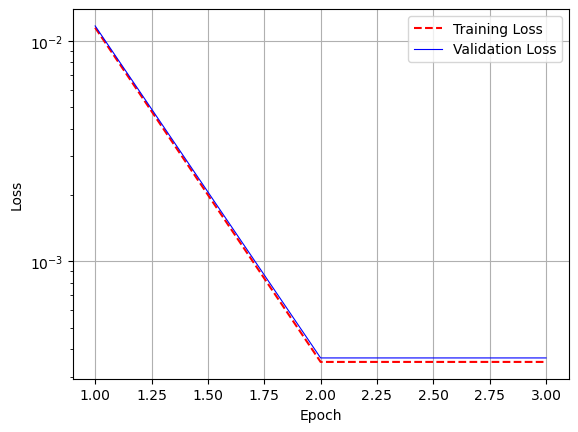

<Figure size 640x480 with 0 Axes>

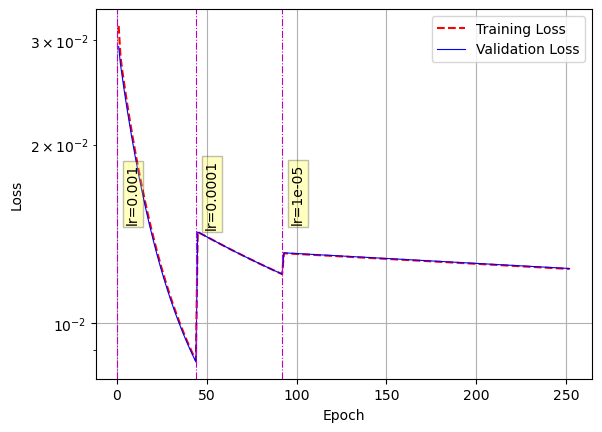

In [45]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=None,
    learning_rate_list=None
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history-preSGD.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()

if use_weights_post_dense == True:
    plt.clf()
    # Visualize loss history
    fig, ax = plot_losses(
        training_loss=train_loss_hist_sgd,
        val_loss=val_loss_hist_sgd,
        lr_change=lr_change_sgd,
        learning_rate_list=learning_rate_list_sgd
    )

    plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
    plt.show()

In [47]:
data_type = 'training'
# data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx, 200:200+300]

for layer in rnn_net.ESN_layers:
    layer.reset_states()

prediction = np.array(rnn_net(data_in[data_idx:data_idx+1, :, :], training=False))[:, 200:200+300, :]

for layer in rnn_net.ESN_layers:
    layer.reset_states()

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=10,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

data_idx : 517


ValueError: Exception encountered when calling layer "esn_4" (type ESN).

in user code:

    File "/home/rkaushik/Documents/Thesis/MLROM/KS/tools/ESN_v4.py", line 338, in _callhelperfn  *
        x = self.ESN_layers[i](x)
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/layers/recurrent.py", line 679, in __call__  **
        return super(RNN, self).__call__(inputs, **kwargs)
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "rnn_4" is incompatible with the layer: expected shape=(32, None, 16), found shape=(1, 375, 16)


Call arguments received:
  • inputs=tf.Tensor(shape=(1, 375, 16), dtype=float32)
  • training=False
  • manual_training=False

In [ ]:
prediction.shape, data_out.shape

In [ ]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

In [ ]:
data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx][0:300]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)


for layer in rnn_net.ESN_layers:
    layer.reset_states()

# prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
prediction = np.array(rnn_net(data_in[data_idx:data_idx+1, :, :], training=False))[:, 0:300, :]
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

for layer in rnn_net.ESN_layers:
    layer.reset_states()

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]

ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)



plt.show()

# Auto Regressive ESN

In [ ]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

In [ ]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 5*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

In [ ]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [ ]:
prediction_lst = []

for layer in rnn_net.ESN_layers:
    layer.reset_states()
    
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :], training=False))[0]

prediction_lst.append(input_preds[-1])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array([[prediction_lst[-1]]])
    output = np.array(rnn_net(data_in_i, training=False))[0, 0]
    prediction_lst.append(output)

In [ ]:
prediction_lst = np.stack(prediction_lst)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

In [ ]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if len(predhor_idx.shape) == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [ ]:
if use_weights_post_dense == True:
    print(rnn_net.postWout.individual_weights)

### Prediction horizon computation

In [ ]:
def plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir,
    savefig_fname='pre_ARtraining',
    bin_width=0.05,
    bin_begin=0.0):
    
    fig, ax = plt.subplots()

    ph_mean = np.mean(prediction_horizon_arr)
    ph_stddev = np.std(prediction_horizon_arr)
    ph_max = np.max(prediction_horizon_arr)
    ph_min = np.min(prediction_horizon_arr)
    
    bin_end = bin_width*np.round((np.max(prediction_horizon_arr)+0.5*bin_width)//bin_width)
    nbins = int(np.round(bin_end/bin_width))

    ax.hist(prediction_horizon_arr, bins=nbins, range = [bin_begin, bin_end], density=True)
    ax.axvline(ph_mean, linewidth=0.9, linestyle='--', color='k')

    ax.set_xlabel('Prediction Horizon (Lyapunov times)')
    ax.set_ylabel('PDF')

    ax.grid(True)
    # ax.set_axisbelow(True)

    ax.text(
        0.01 + ax.transAxes.inverted().transform(ax.transData.transform([prediction_horizon, 0]))[0],
        0.8,
        'mean',
        rotation=90,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor=np.array([255,255,153])/255, alpha=1, boxstyle='square,pad=0.2'),
        transform=ax.transAxes
    )

    text_xy = [0.95, 0.95]
    ax.text(
        text_xy[0],
        text_xy[1],
        'mean : {:.4f}\nmax : {:.4f}\nmin : {:.4f}\nstddev : {:.4f}'.format(
            ph_mean,
            ph_max,
            ph_min,
            ph_stddev,
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='right',
        verticalalignment='top'
    )

    ax.set_title('nbins = {}'.format(nbins))
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    fig.savefig(save_dir+'/'+savefig_fname+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()

In [ ]:
num_runs = 100
num_runs = np.min([num_runs, maxpossible_num_runs])

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

savefig_fname = 'pre_ARtraining-'+data_to_consider+'data'
npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
plot_dir = '/plots'

analysis_time = time.time()

sidx1 = dir_name_rnn[::-1].index('/')
sidx2 = dir_name_rnn[-sidx1-2::-1].index('/')
print(dir_name_rnn[-(sidx1+sidx2+1):])

prediction_horizon_arr = np.empty(shape=num_runs)

for i in range(num_runs):
    data_idx = data_idx_arr[i]

    # for j in range(len(rnn_data_boundary_idx_arr)):
    #     if data_idx < rnn_data_boundary_idx_arr[j]:
    #         case_idx = j
    #         break
    lyap_time = lyapunov_time_arr[0]

    ### picking the data
    data_ = data_in[0:1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]

    ### doing the predictions
    prediction_lst = []

    for layer in rnn_net.ESN_layers:
        layer.reset_states()

    input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :], training=False))[0]

    prediction_lst.append(input_preds[-1])

    for j in range(1, num_sample_output_AR):
        data_in_j = np.array([[prediction_lst[-1]]])
        output = np.array(rnn_net(data_in_j, training=False))[0, 0]
        prediction_lst.append(output)
    prediction_lst = np.stack(prediction_lst)
    prediction_lst = invert_normalization(prediction_lst, normalization_arr)
    
    data_out = data_[0, num_sample_input_AR:num_sample_input_AR+num_sample_output_AR, :]
    data_out = invert_normalization(data_out, normalization_arr)

    ### Error and prediction horizon
    # error = np.linalg.norm(data_out[:, :] - prediction[i, :, :], axis=1)
    error = (data_out[:, :] - prediction_lst[:, :])**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

    predhor_idx = np.where(error >= error_threshold)[0]
    if predhor_idx.shape[0] == 0:
        predhor_idx = error.shape[0]
    else:
        predhor_idx = predhor_idx[0]

    prediction_horizon_arr[i] = predhor_idx*dt_rnn/lyap_time

median_idx = int(np.round(0.5*num_runs-1))
quartile_1_idx = int(np.round(0.25*num_runs-1))
quartile_3_idx = int(np.round(0.75*num_runs-1))

prediction_horizon_arr.sort()

median = prediction_horizon_arr[median_idx]
quartile_1 = prediction_horizon_arr[quartile_1_idx]
quartile_3 = prediction_horizon_arr[quartile_3_idx]
IQR = quartile_3 - quartile_1

prediction_horizon = np.mean(prediction_horizon_arr)
stddev_ph = np.std(prediction_horizon_arr)

s = 'error_threshold = {}\n'.format(error_threshold)
s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
s += '1st quartile : {}, 3rd quartile : {}'.format(quartile_1, quartile_3)

print('\n'+s)

plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir=dir_name_rnn+plot_dir,
    savefig_fname=savefig_fname
)

npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
np.savez(
    dir_name_rnn+npsavedata_fname,
    prediction_horizon_arr=prediction_horizon_arr,
    error_threshold=error_threshold,
)

with open(dir_name_rnn+npsavedata_fname+'--statistics.txt', 'w') as fl:
    fl.write(s)

print('analysis time : {} s\n'.format(time.time() - analysis_time))